In [78]:
# import packages
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
from helper import *
import ipywidgets as widgets

# variables
time_period = (1, 2, 3, 4, 5) # 5 different implementation of progression order  
n_patients = 0 # number of patients included in the model  
n_sessions = 0 # number of sessions included in the model  
usage_time: how many months the patient has been using the app  
usage_freq: how frequent the patient uses the app  

Clean Data

In [79]:
# querying from the SQL database, 2 mins for q3 table

# from connection import *

# con = connect()
# df = SQL("select * from constant_therapy.q3", con)
# df = df.rename(columns={'session_id':"id"})

In [80]:
# 1 min, data saved from previous runs
df = pd.read_csv("data/model_data.csv")
df.head()

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_11152/2410965418.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/model_data.csv")


,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
1,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
2,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
3,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
4,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"


In [81]:
# 20 seconds
# deficit_ids = df.groupby("patient_id")["deficit_id"].apply(set).reset_index()
# df = df.drop(columns="deficit_id")
# df = df.merge(deficit_ids, on="patient_id", how="left")

In [82]:
# 1 min
# domain_ids = df.groupby("id")["domain_id"].apply(set).reset_index()
# df = df.drop(columns="domain_id")
# df = df.merge(domain_ids, on="id", how="left")

In [83]:
df = df.drop_duplicates(subset="id")

In [84]:
df.nunique()

id               7008614
patient_id         68780
start_time       6693130
task_type_id         173
task_level            12
domain_ids            34
domain_scores     191396
dtype: int64

In [85]:
# df.to_csv("data/consolidate_data_w_ds.csv", index=False)
## careful when reading, will read set as string
# df = pd.read_csv("data/consolidate_data.csv", index_col=[0])
df

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
5,11042076,2171,2018-04-15 23:48:00,4,1,"6,10","0.3050,0.8000"
10,11057448,2171,2018-04-16 21:55:03,4,1,"6,10","0.3160,0.7930"
15,11069816,2171,2018-04-17 17:54:54,4,1,"6,10","0.3160,0.8070"
20,11742188,2171,2018-06-05 17:35:50,4,1,"6,10","0.2740,0.8360"
...,...,...,...,...,...,...,...
80506826,41286101,584095,2023-05-22 17:29:53,255,3,12,0.6790
80506830,41465313,584095,2023-05-25 19:56:38,255,3,12,0.6670
80506834,41530297,584095,2023-05-30 03:44:54,255,3,12,0.6670
80506838,41585933,584095,2023-05-31 00:33:20,255,3,12,0.6550


All data has been consolidated, there should be no duplicate sessions for different disorders/domains.
We want to add time_period, usage_time, and usage_freq to the dataset.

**This part doesn't need to be run if it's claire's data**

In [86]:
# progression_order_df = pd.read_csv("data/progression_order.csv", index_col=[0])
# progression_order_df.rename(columns={'time_implemented':'start_time'}, inplace=True)
# progression_order_df["start_time"] = pd.to_datetime(progression_order_df["start_time"])
# df["start_time"] = pd.to_datetime(df["start_time"])

In [87]:
# def time_period_convert(dd):
#     dates = sorted(pd.unique(progression_order_df["start_time"]))
#     if dd < pd.to_datetime(dates[1]):
#         return 1
#     elif dd < pd.to_datetime(dates[2]):
#         return 2
#     elif dd < pd.to_datetime(dates[3]):
#         return 3
#     elif dd < pd.to_datetime(dates[4]):
#         return 4
#     else:
#         return 5

In [88]:
# added time period, takes around 8-9 minutes to run
# df["time_period"] = df["start_time"].apply(time_period_convert)
# df

In [89]:
# progression_order_df["time_period"] = progression_order_df["start_time"].apply(time_period_convert)
# progression_order_df

Adding Usage Time
* this is by patient
* need a patient dataframe vs session dataframe (df)

In [90]:
df["start_time"] = pd.to_datetime(df["start_time"])
df = df.sort_values(by="start_time")

In [91]:
patients = (df.groupby("patient_id")["start_time"].max() - df.groupby("patient_id")["start_time"].min()).reset_index()
patients.columns = ["patient_id", "usage_time"]
patients["usage_time"] = patients["usage_time"].dt.days + 1
patients

,patient_id,usage_time
0,2171,1500
1,2281,1967
2,2466,894
3,2517,1140
4,3882,1
...,...,...
68775,560491,49
68776,565981,57
68777,568669,268
68778,575513,67


Add usage_freq for patient dataframe
* using the simplest way of calculating frequency
* how to get rid of outlier

In [92]:
patients["session_count"] = df.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients["unique_days"] = df.groupby("patient_id")["start_time"].nunique().reset_index(name="days")["days"]
patients

,patient_id,usage_time,session_count,unique_days
0,2171,1500,3221,3221
1,2281,1967,618,618
2,2466,894,12,12
3,2517,1140,1521,1521
4,3882,1,2,2
...,...,...,...,...
68775,560491,49,60,60
68776,565981,57,1105,1105
68777,568669,268,1103,1103
68778,575513,67,118,118


In [93]:
patients["usage_freq"] = patients["unique_days"] / patients["usage_time"]
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,2171,1500,3221,3221,2.147333
1,2281,1967,618,618,0.314184
2,2466,894,12,12,0.013423
3,2517,1140,1521,1521,1.334211
4,3882,1,2,2,2.000000
...,...,...,...,...,...
68775,560491,49,60,60,1.224490
68776,565981,57,1105,1105,19.385965
68777,568669,268,1103,1103,4.115672
68778,575513,67,118,118,1.761194


How to remove outlier

In [94]:
from sklearn.cluster import DBSCAN

def filter_datetime_outliers(data, column="start_time", eps_days=7, min_samples=10):
    """
    Filters outlier dates by clustering with DBSCAN.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing datetime column.
    - column (str): Name of the datetime column.
    - eps_days (int): Max days apart for dates to be considered in the same cluster.
    - min_samples (int): Minimum number of points required to form a cluster.
    
    Returns:
    - pd.DataFrame: Filtered DataFrame containing only clustered dates.
    """
    df = data.copy()

    # Convert dates to numerical timestamps
    df["timestamp"] = df[column].astype(np.int64) // 10**9  # Convert to seconds

    # Apply DBSCAN clustering
    eps_seconds = eps_days * 24 * 60 * 60  # Convert days to seconds
    clustering = DBSCAN(eps=eps_seconds, min_samples=min_samples).fit(df[["timestamp"]])
    
    # Assign cluster labels
    df["cluster"] = clustering.labels_

    # Remove outliers (DBSCAN labels outliers as -1)
    filtered_df = df[df["cluster"] != -1].drop(columns=["timestamp", "cluster"])

    return filtered_df

In [95]:
# modified from https://stackoverflow.com/questions/56750841/how-to-trim-outliers-in-dates-in-python
def datetime_outlier(data):
    qa = data["start_time"].quantile(0.2) #lower 10%
    qb = data["start_time"] #higher 10%
    #remove outliers
    xf = data[(data.start_time >= qa) & (data.start_time <= qb)]
    return xf

In [96]:
# about a min
patients_v2 = df.groupby("patient_id").apply(filter_datetime_outliers).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_11152/3640673850.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patients_v2 = df.groupby("patient_id").apply(filter_datetime_outliers).reset_index(drop=True)


In [97]:
df[df.patient_id == 584095].sort_values(by="start_time")

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
80506550,38748396,584095,2022-12-07 01:33:52,134,1,3,0.0370
80506678,38748397,584095,2022-12-07 01:36:22,212,6,5,0.0000
80506554,38840767,584095,2022-12-13 02:41:39,134,1,3,0.0370
80506682,38840768,584095,2022-12-13 02:47:04,212,6,5,0.4200
80506422,38840769,584095,2023-01-06 22:15:03,13,5,2,0.0000
...,...,...,...,...,...,...,...
80506642,41858185,584095,2023-06-17 20:29:23,207,5,12,0.5330
80506478,41858186,584095,2023-06-17 20:46:31,26,4,5,0.5350
80506498,41858187,584095,2023-06-17 20:52:27,26,5,5,0.5350
80506626,41858188,584095,2023-06-21 00:26:53,167,1,"4,5","0.8750,0.5550"


In [98]:
patients_v2[patients_v2.patient_id == 584095].sort_values(by="start_time")

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
6608399,40946268,584095,2023-04-20 00:22:17,212,10,5,0.3350
6608400,40946269,584095,2023-04-20 00:41:38,13,5,2,0.3170
6608401,40946270,584095,2023-04-20 00:46:13,254,3,5,0.3350
6608402,41058178,584095,2023-04-26 23:26:56,215,1,"3,13","0.0810,0.0810"
6608403,41058179,584095,2023-04-26 23:29:14,215,7,"3,13","0.1850,0.2710"
...,...,...,...,...,...,...,...
6608490,41858185,584095,2023-06-17 20:29:23,207,5,12,0.5330
6608491,41858186,584095,2023-06-17 20:46:31,26,4,5,0.5350
6608492,41858187,584095,2023-06-17 20:52:27,26,5,5,0.5350
6608493,41858188,584095,2023-06-21 00:26:53,167,1,"4,5","0.8750,0.5550"


In [99]:
patients_v2.nunique()

id               6608495
patient_id         29459
start_time       6327908
task_type_id         173
task_level            12
domain_ids            34
domain_scores     187217
dtype: int64

In [100]:
patients_filtered = (patients_v2.groupby("patient_id")["start_time"].max() - patients_v2.groupby("patient_id")["start_time"].min()).reset_index()
patients_filtered.columns = ["patient_id", "usage_time"]
patients_filtered["usage_time"] = patients_filtered["usage_time"].dt.days + 1
patients_filtered

,patient_id,usage_time
0,2171,1442
1,2281,1944
2,2517,699
3,4032,534
4,4073,10
...,...,...
29454,560491,41
29455,565981,57
29456,568669,268
29457,575513,46


In [101]:
patients_filtered["session_count"] = patients_v2.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients_filtered["unique_days"] = patients_v2.groupby("patient_id")["start_time"].nunique().reset_index(name="days")["days"]
patients_filtered["usage_freq"] = patients_filtered["unique_days"] / patients_filtered["usage_time"]

Check that the length of patients_filtered is less than or equal to the length of patients

In [102]:
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,2171,1500,3221,3221,2.147333
1,2281,1967,618,618,0.314184
2,2466,894,12,12,0.013423
3,2517,1140,1521,1521,1.334211
4,3882,1,2,2,2.000000
...,...,...,...,...,...
68775,560491,49,60,60,1.224490
68776,565981,57,1105,1105,19.385965
68777,568669,268,1103,1103,4.115672
68778,575513,67,118,118,1.761194


In [103]:
patients_filtered

,patient_id,usage_time,session_count,unique_days,usage_freq
0,2171,1442,3140,3140,2.177531
1,2281,1944,576,576,0.296296
2,2517,699,1484,1484,2.123033
3,4032,534,123,123,0.230337
4,4073,10,10,10,1.000000
...,...,...,...,...,...
29454,560491,41,58,58,1.414634
29455,565981,57,1105,1105,19.385965
29456,568669,268,1103,1103,4.115672
29457,575513,46,111,111,2.413043


## INTERACT
Filter seems to work for time outlier, so we using patient_filtered

In [ ]:
# interact to figure out what thresholds to use

@widgets.interact_manual(usage_time=(1, 365), usage_freq=(0.0, 1.0))
def visualize(usage_time, usage_freq):
    temp = patients_filtered[patients_filtered.usage_time > usage_time]
    temp = temp[temp.usage_freq > usage_freq]
    return "number of patients: %d" %(temp["patient_id"].nunique())

interactive(children=(IntSlider(value=183, description='usage_time', max=365, min=1), FloatSlider(value=0.5, d…

In [116]:
# create the according filtered patients dataframe

usage_time = input("usage time: ")
print("inputted ", usage_time)
usage_freq = input("usage_freq: ")
print("inputted ", usage_freq)

inputted  95
inputted  0.2


In [117]:
filtered_patients_list = patients_filtered[patients_filtered.usage_time > float(usage_time)]
filtered_patients_list = filtered_patients_list[filtered_patients_list.usage_freq > float(usage_freq)]

In [118]:
filtered_patients_list.nunique()

patient_id       4399
usage_time       1386
session_count    1980
unique_days      1986
usage_freq       4298
dtype: int64

In [119]:
# create filtered session dataframe from filtered patients data
temp_lst = filtered_patients_list["patient_id"]
sessions_filter_df = df[df.patient_id.isin(temp_lst)]
sessions_filter_df

,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
11225782,6334548,97021,2017-03-13 00:49:21,79,3,9,0.6000
17344069,8391327,134153,2017-09-21 17:46:51,37,1,"1,10,11","0.3430,0.3640,0.7600"
19382641,8814541,139776,2017-10-25 21:53:53,76,1,"6,8","0.7500,0.5000"
14401772,8970881,119855,2017-11-07 20:06:06,24,4,12,0.5640
20663123,9156751,144485,2017-11-22 15:01:40,10,4,"6,7","0.4000,0.4000"
...,...,...,...,...,...,...,...
4080248,41974214,35004,2023-06-22 03:09:03,235,6,14,0.8670
6783830,41976112,54405,2023-06-22 03:15:19,136,6,13,0.5410
6760870,41976113,54405,2023-06-22 03:16:52,13,2,2,0.3800
6765630,41976114,54405,2023-06-22 03:20:17,26,2,5,0.2580


In [120]:
# filter based on time_period
# time_period_n = input("time period: ")
# sessions_filter_df = sessions_filter_df[sessions_filter_df.time_period == int(time_period_n)]

In [110]:
# sessions_filter_df.to_csv("data/filtered_model_data.csv", index=False)

In [121]:
sessions_filter_df[["id", "patient_id"]].nunique()

id            5839764
patient_id       4399
dtype: int64

In [124]:
filtered_patients_list[["session_count"]].mean()

session_count    1293.34667
dtype: float64

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_11152/2775516111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = df1['start_time'].dt.date
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_11152/2775516111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'] = df2['start_time'].dt.date
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_11152/2775516111.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

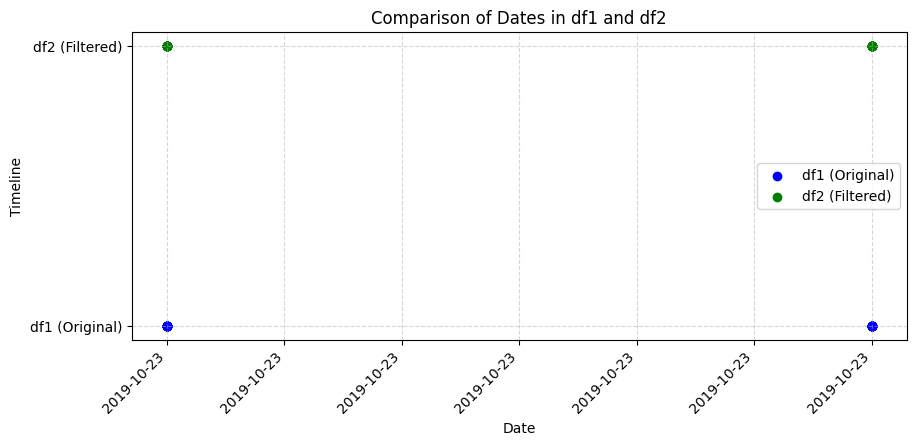

In [122]:
import random

pid = random.choice(pd.unique(patients_v2["patient_id"]))
df1 = df[df.patient_id == pid]
df2 = patients_v2[patients_v2.patient_id == pid]

# Convert start_time to just the date (drop time details)
df1['date'] = df1['start_time'].dt.date
df2['date'] = df2['start_time'].dt.date

# Find missing dates
missing_dates = set(df1['date']) - set(df2['date'])

# Create the figure
fig, ax = plt.subplots(figsize=(10, 4))

# Plot all dates from df1
ax.scatter(df1['date'], [1] * len(df1), label='df1 (Original)', color='blue', marker='o')

# Plot retained dates from df2
ax.scatter(df2['date'], [2] * len(df2), label='df2 (Filtered)', color='green', marker='o')

# Highlight missing dates
for missing in missing_dates:
    ax.scatter(missing, 1, color='red', marker='x', label="Removed" if missing == list(missing_dates)[0] else "")

# Formatting
ax.set_yticks([1, 2])
ax.set_yticklabels(["df1 (Original)", "df2 (Filtered)"])
ax.set_xticklabels(df1['date'], rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Timeline")
plt.title("Comparison of Dates in df1 and df2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

Check if there are any duplicate domain ids for each session

In [72]:
sessions_filter_df[sessions_filter_df["domain_id"].apply(lambda x: len(x) != 1)]

KeyError: 'domain_id'

Now that we have the filtered dataframe, we want to start performance metric calculation
* add progression order  
**for now**  
* calculate percentile of each session for each domain
* for each patient, average percentile value across all domains **at the time**, which is our final performance metric calculation

This part doesn not need to be run if it's claire's data

In [ ]:
# expand sessions due to compressed domain
sessions_filter_df = sessions_filter_df.explode("domain_id").reset_index()

In [ ]:
# progression_order_df[progression_order_df.time_period == int(time_period_n)]

In [ ]:
sessions_filter_df.dtypes

In [ ]:
def set_to_int(s):
    if isinstance(s, int): return s
    return s.pop()

In [ ]:
sessions_filter_df["domain_id"] = sessions_filter_df["domain_id"].apply(set_to_int)
sessions_filter_df

get domain scores

In [ ]:
domain_scores = pd.read_csv("data/domain_score.csv")
domain_scores.pop(domain_scores.columns[0])
domain_scores.head()

In [ ]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

def expand_dataframe(df):
    new_rows = []
    for _, row in df.iterrows():
        values_a, values_b = process_row(row)
        row['domain_ids'] = values_a
        row['domain_scores'] = values_b
        new_rows.append(row)
    return pd.DataFrame(new_rows)

# Example usage:
data = {'domain_ids': [0.1, "0.2, 0.4, 0.7"],
        'domain_scores': [0.3, "0.5, 0.6, 0.8"],
        'C': [1, 2]}
df = pd.DataFrame(data)
expanded_df = expand_dataframe(df)
print(expanded_df)

In [ ]:
domain_scores_expanded = expand_dataframe(domain_scores)

In [ ]:
domain_scores

In [ ]:
domain_scores_expanded

In [ ]:
df_ds = pd.merge(sessions_filter_df, domain_scores, how='inner', left_on='id', right_on='id', suffixes=('', '_y'))
df_ds.drop(df_ds.filter(regex='_y$').columns, axis=1, inplace=True)
df_ds

In [ ]:
df_ds.drop(["index"], axis=1, inplace=True)

In [ ]:
df_ds.columns

In [ ]:
df_ds_1 = df_ds[["id", "patient_id", "domain_ids", "domain_scores", "start_time_min"]]
df_ds_1

In [ ]:
df_ds_1 = df_ds_1.drop_duplicates(subset="id")

In [ ]:
df_ds_1.to_csv("data/filtered_ds.csv", index=False)

In [ ]:
df_ds_1

progression order code

In [ ]:
# add progression order
# sessions_filter_df = sessions_filter_df.merge(progression_order_df[progression_order_df.time_period == int(time_period_n)], on=["task_type_id", "task_level", "domain_id"]).reset_index()
# sessions_filter_df

Get Percentile

In [ ]:
# get percentile of a domain
# def get_percentile(data):
#     data["percentile"] = data["progression_order"].rank(pct=True)
#     return data

In [ ]:
## get percentile for each domain
# df_pct = sessions_filter_df.groupby("domain_id").apply(get_percentile).reset_index(drop=True)
# df_pct

In [ ]:
## clean dataframe, does not need to be run if Claire's data
# df_pct.drop(df_pct.columns[[0, 11, 16, 17, 19, 20]], axis=1, inplace=True)
# df_pct

In [ ]:
# df_pct.to_csv("data/raw_percentile_time5.csv", index=False)

Get overall

In [ ]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score(data : pd.DataFrame):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data = data.sort_values(by="start_time_min").reset_index(drop=True)

    for idx, row in data.iterrows():
        
        updated_domain_pct[row["domain_ids"]] = row["domain_scores"] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # set score to the score list
    data["score"] = scores
    return data

In [ ]:
df_ds_1 = df_ds_1.drop_duplicates(subset="id")

In [ ]:
df_ds_1.shape

In [ ]:
## get performance metric by each patient for each session
final_df = df_ds_1.groupby("patient_id").apply(get_score).reset_index(drop=True)
final_df

## Question
* right now there are duplicate sessions since domain percentile was calulated separately, how do we feed this to the model?
* task changes visualization -> try to explain the fluctuations
* add overall timeline

* update only the domains that have been practiced
* keep other domains constant
* how much they switch domains

In [ ]:
import random
pid = random.choice(pd.unique(final_df["patient_id"]))
print(pid)

In [ ]:
sns.scatterplot(data=final_df[final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_ids", palette="bright").set_title(pid)
plt.plot(final_df[final_df.patient_id == pid]["start_time_min"], final_df[final_df.patient_id == pid]["score"], 'k')

In [ ]:
sns.lineplot(data=final_df[final_df.patient_id == pid], x="start_time_min", y="domain_scores", hue="domain_ids", palette="bright").set_title(pid)

Second metric calculation:
* keep other domains constant 
* how do we start off each domain -> average of when people first start out or just average

In [ ]:
df_pct

First: average across all sessions

In [ ]:
df_pct.groupby("domain_id")["percentile"].mean()

In [ ]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score_avg(data):
    # initialize score with average
    score = [0.5 for i in range(14)]
    scores = []
    

    data = data.sort_values(by="start_time_min") # sort data by time

    for idx, row in data.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores.append(sum(score) / len(score))
    data["score"] = scores
    return data

In [ ]:
## get performance metric by each patient for each session
avg_final_df = df_pct.groupby("patient_id").apply(get_score_avg).reset_index(drop=True)
avg_final_df

Let's look at results

In [ ]:
import random
pid = random.choice(pd.unique(avg_final_df["patient_id"]))
print(pid)
sns.scatterplot(data=avg_final_df[avg_final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(avg_final_df[avg_final_df.patient_id == pid]["start_time_min"], avg_final_df[avg_final_df.patient_id == pid]["score"])

Second average method: average starting point

In [ ]:
df_pct

In [ ]:
domain_avg = final_df.sort_values(by="start_time_min")
domain_avg = domain_avg.drop_duplicates(subset=["patient_id", "domain_ids"])

In [ ]:
domain_avg["domain_id"].unique()

In [ ]:
lst = list(domain_avg.groupby("domain_ids")["domain_scores"].mean().reset_index()["domain_scores"])
lst

In [ ]:
lst = lst[:10] + [0] + lst[10:]
lst

In [ ]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score_avg2(data):
    # initialize score with average
    global lst
    score = lst
    scores = []
    
    data = data.sort_values(by="start_time_min") # sort data by time

    for idx, row in data.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores.append(sum(score) / len(score))
    data["score"] = scores
    return data

In [ ]:
## get performance metric by each patient for each session
avg_final_df2 = df_pct.groupby("patient_id").apply(get_score_avg2).reset_index(drop=True)
avg_final_df2

In [ ]:
import random
pid = random.choice(pd.unique(avg_final_df2["patient_id"]))

print(pid)
sns.scatterplot(data=avg_final_df2[avg_final_df2.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(avg_final_df2[avg_final_df2.patient_id == pid]["start_time_min"], avg_final_df2[avg_final_df2.patient_id == pid]["score"])

Normalization

In [ ]:
df_pct

In [ ]:
sorted_df = df_pct.sort_values(by="start_time_min")
sorted_df

In [ ]:
# initial score
initial = lst

In [ ]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_names

In [ ]:
# create domain score columns, input a patient's session data
def create_domain_scores(data):
    global initial
    global column_names
    score = initial
    data = data.sort_values(by="start_time_min")
    scores = np.zeros((len(data), 14))
    i = 0

    for idx, row in data.iterrows():
        score[int(row["domain_ids"] - 1)] = row["domain_scores"]
        # set score to the score list average
        scores[i] = score
        i += 1
    data = pd.concat([data, pd.DataFrame(scores, columns=column_names)], axis=1)
    return data

In [ ]:
scores_df = final_df.groupby("patient_id").apply(create_domain_scores).reset_index(drop=True)
scores_df

In [ ]:
final_df.to_csv("data/domain_scores_CT.csv", index=False)

In [ ]:
# nomralize scores
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# scores only df
scores_df_minmax = MinMaxScaler().fit_transform(scores_df[column_names])

In [ ]:
minmax_df = scores_df
minmax_df[column_names] = scores_df_minmax

In [ ]:
minmax_df.columns

In [ ]:
minmax_df['score'] = minmax_df[column_names].mean(axis=1)
minmax_df

In [ ]:
avg_final_df2[avg_final_df2.patient_id == pid]

In [ ]:
minmax_df[minmax_df.patient_id == pid]

In [ ]:
import random
pid = random.choice(pd.unique(minmax_df["patient_id"]))
print(pid)
sns.scatterplot(data=minmax_df[minmax_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(minmax_df[minmax_df.patient_id == pid]["start_time_min"], minmax_df[minmax_df.patient_id == pid]["score"])

In [ ]:
temp = minmax_df[minmax_df.patient_id == pid]

In [ ]:
sns.lineplot(data=temp, x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)

In [ ]:
sns.lineplot(data=temp, x="start_time_min", y="progression_order", hue="domain_id", palette="bright").set_title(pid)

In [ ]:
temp[["domain_id", "task_type_id", "task_level", "score", "progression_order", "domain 14 score", "start_time_min", "id"]]

Create day-to-day score -> combine sessions of the same domain -> average that then average across domains -> one score for each day instead of each session

Filter out fluctations

In [ ]:
# return false if there's fluctation given a person's data
def fluctate(data):
    data = data.sort_values(by="start_time_min").reset_index() # sort data by time
    d = dict()
    for idx, row in data.iterrows():
        if row["start_time"] not in d:
            d[row["start_time"]] = [row["domain_id"]]
        else:
            if row["domain_id"] in d[row["start_time"]]:
                return False
            else:
                d[row["start_time"]].append(row["domain_id"])
    return True

In [ ]:
filter_lst = minmax_df.groupby("patient_id").apply(fluctate).reset_index()

In [ ]:
filter_lst = filter_lst.rename(columns={0: "a"})
filter_lst

In [ ]:
filter_lst[filter_lst.a]["patient_id"]

In [ ]:
flutuate_data = minmax_df.loc[minmax_df["patient_id"].isin(filter_lst[filter_lst.a]["patient_id"])].reset_index()
flutuate_data

Filtering doesn't seem to work, work on incorporating accuracy

In [ ]:
df_pct

In [ ]:
def new_score(row):
    score = None
    p = [1.05, 1.0, 0.9, 0.8]
    if row.accuracy > .90:
        score = row.percentile * p[0]
    elif row.accuracy > .60:
        score = row.percentile * p[1]
    elif row.accuracy > .40:
        score = row.percentile * p[2]
    else:
        score = row.percentile * p[3]
    return score

In [ ]:
# 12 seconds
df_pscore = df_pct.copy(deep=True)
df_pscore["percentile"] = df_pscore.apply(new_score, axis=1)
df_pscore

In [ ]:
def combine(data):
    data = data.sort_values(by="start_time_min").reset_index() # sort data by time
    return data.groupby(["domain_id", "start_time"])["percentile"].mean().reset_index()

In [ ]:
# create domain score columns, input a patient's session data
def create_domain_scores2(data):
    global initial
    global column_names
    score = initial
    data = data.sort_values(by="start_time_min").reset_index() # sort data by time
    i = 0
    combined_scores = combine(data)
    scores = np.zeros((len(combined_scores), 14))
    combined_scores = combined_scores.sort_values(by="start_time").reset_index()
    for idx, row in combined_scores.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores[i] = score
        i += 1
    data = data.drop_duplicates(subset=["domain_id", "start_time"]).reset_index()
    data = pd.concat([data, pd.DataFrame(scores, columns=column_names)], axis=1)
    return data

In [ ]:
df_pscore2 = df_pscore.groupby("patient_id").apply(create_domain_scores2).reset_index(drop=True)
df_pscore2

In [ ]:
column_n = column_names

In [ ]:
scores_df_minmax2 = MinMaxScaler().fit_transform(df_pscore2[column_n])

In [ ]:
minmax_df2 = df_pscore2
minmax_df2[column_n] = scores_df_minmax2

In [ ]:
minmax_df2['score'] = minmax_df2[column_n].mean(axis=1)
minmax_df2

In [ ]:
import random
pid = random.choice(pd.unique(minmax_df2["patient_id"]))
print(pid)
sns.scatterplot(data=minmax_df2[minmax_df2.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(minmax_df2[minmax_df2.patient_id == pid]["start_time_min"], minmax_df2[minmax_df2.patient_id == pid]["score"], 'k')

In [ ]:
minmax_df2

In [ ]:
temp = df_pct[df_pct.patient_id == 30679]
temp = temp.sort_values(by="start_time_min").reset_index()
temp[temp.domain_id == 10][["accuracy", "progression_order", "percentile"]][temp.progression_order == 3]

In [ ]:
temp = create_domain_scores2(df_pscore[df_pscore.patient_id == 87299])
temp[temp.domain_id == 4][["accuracy", "progression_order", "domain 4 score", "start_time"]]